In [1]:
import os
import numpy as np
import pywt
import random
import seaborn as sns
import tensorflow as tf
from keras.layers import Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
  Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, 
  Dense, Dropout, GRU, Concatenate, LayerNormalization, MultiHeadAttention, 
  Reshape, Multiply, Softmax
)
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from utils import (
  encode_labels, check_gpu_availability, plot_loss_accuracytupian, 
  evaluate_model, plot_confusion_matrixtupian, plot_tsne, 
  plot_precision_recall_curve_multiclasstupian, plot_roc_curve_multiclasstupian, 
  AdjustLearningRateCallback, denoise2,count_labels,denoise2_iterative2,AdjustLearningRateCallback
)
from utils import plot_precision_recall_curve_multiclass,plot_roc_curve_multiclass2,calculate_g_mean,plot_confusion_matrix,plot_confusion_matrix2,plot_loss_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1DTranspose


c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
check_gpu_availability()

GPU 可用


In [3]:
datafilename1 = "C:\\Users\\Administrator\\Desktop\\database\\cinc2017denoise.npz"
data1 = np.load(datafilename1, allow_pickle=True)
X_train, y_train, X_val, y_val, X_test, y_test = data1['ecgstrain'], data1['labelstrain'], data1['ecgsval'], data1['labelsval'], data1['ecgstest'], data1['labelstest']

In [4]:
y_train = encode_labels(y_train)
y_test = encode_labels(y_test)
y_val= encode_labels(y_val)
y_train = to_categorical(y_train, num_classes=4)
y_val=to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [5]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Concatenate

def ince_block(inputs, filters, strides=1):
    x1 = Conv1D(filters, 3, strides=strides, padding='same')(inputs)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv1D(filters, 5, strides=1, padding='same')(inputs)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv1D(filters, 9, strides=1, padding='same')(inputs)
    x3 = BatchNormalization()(x3)
    x3 = Activation('relu')(x3)

    x4 = Conv1D(filters, 17, strides=1, padding='same')(inputs)
    x4 = BatchNormalization()(x4)
    x4 = Activation('relu')(x4)

    x = Concatenate()([x1, x2, x3, x4])
    x = Activation('relu')(x)
    return x


In [6]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Reshape, Dense, Multiply
def se_block(input_tensor, reduction_ratio=16):
  channels = input_tensor.shape[-1]
  x = GlobalAveragePooling1D()(input_tensor)
  x = Reshape((1, channels))(x)
  x = Dense(channels // reduction_ratio, activation='relu', use_bias=False)(x)
  x = Dense(channels, activation='sigmoid', use_bias=False)(x)
  x = Multiply()([input_tensor, x])
  return x


In [7]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, Dense, GRU
from tensorflow.keras.models import Model
import tensorflow as tf

def residual_shrinkage_block_1d(incoming, nb_blocks, out_channels, downsample=False, downsample_strides=2, activation='relu', kernel_size=31,batch_norm=True, bias=True, weights_init='variance_scaling', bias_init='zeros', regularizer='l2', weight_decay=0.0001, trainable=True, name="ResidualShrinkageBlock"):
  residual = incoming
  in_channels = incoming.shape[-1]
  for i in range(nb_blocks):
    identity = residual
    if downsample:
      downsample_strides = 2
    else:
      downsample_strides = 1
    
    if batch_norm:
      residual = BatchNormalization()(residual)
    residual = Activation(activation)(residual)
    residual = Conv1D(out_channels, kernel_size=kernel_size, strides=downsample_strides, padding='same', kernel_initializer=weights_init, use_bias=bias, kernel_regularizer=regularizer, bias_regularizer=regularizer)(residual)
    
    if batch_norm:
      residual = BatchNormalization()(residual)
    residual = Activation(activation)(residual)
    residual = Conv1D(out_channels, kernel_size=kernel_size, strides=1, padding='same', kernel_initializer=weights_init, use_bias=bias, kernel_regularizer=regularizer, bias_regularizer=regularizer)(residual)
    
    # Thresholding
    abs_mean = tf.reduce_mean(tf.abs(residual), axis=1, keepdims=True)
    scales = Dense(out_channels // 4, activation='linear', kernel_regularizer=regularizer, kernel_initializer=weights_init)(abs_mean)
    scales = BatchNormalization()(scales)
    scales = Activation('relu')(scales)
    scales = Dense(out_channels, activation='linear', kernel_regularizer=regularizer, kernel_initializer=weights_init)(scales)
    scales = tf.sigmoid(scales)
    thres = abs_mean * scales
    residual = tf.sign(residual) * tf.maximum(tf.abs(residual) - thres, 0)
    
    # Downsampling and projection
    if downsample_strides > 1:
      identity = Conv1D(out_channels, 1, strides=downsample_strides, padding='same', kernel_initializer=weights_init, use_bias=bias, kernel_regularizer=regularizer, bias_regularizer=regularizer)(identity)
    
    if in_channels != out_channels or downsample:
      identity = Conv1D(out_channels, 1, strides=1, padding='same', kernel_initializer=weights_init, use_bias=bias, kernel_regularizer=regularizer, bias_regularizer=regularizer)(identity)
    
    residual = residual + identity

  return residual


In [8]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Add

def res_block31_dilated_causal(inputs, filters, kernel_size=31, dilation_rate=2,strides=1):
  shortcut = inputs
  # 使用扩张卷积和因果卷积
  x = Conv1D(filters, kernel_size, strides=1, padding='causal', dilation_rate=dilation_rate)(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv1D(filters, kernel_size, strides=1, padding='causal', dilation_rate=dilation_rate)(x)
  x = BatchNormalization()(x)
  
  # 调整shortcut路径以匹配主路径的维度
  if inputs.shape[-1] != filters:
    shortcut = Conv1D(filters, 1, strides=strides, padding='causal')(inputs)  
    shortcut = BatchNormalization()(shortcut)
  
  x = Add()([x, shortcut])
  x = Activation('relu')(x)
  return x


In [9]:
def res_block31(inputs, filters, kernel_size=31, strides=1):
    shortcut = inputs
    
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    if strides != 1 or inputs.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=strides, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [10]:
def resxnet(num_classes=4):
    input_1 = Input(shape=(4500,1))
    x = Conv1D(64, 12, strides=2, padding='same')(input_1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ince_block(x,64)
    x = residual_shrinkage_block_1d(x, nb_blocks=1, out_channels=32, downsample=True)
    x = res_block31_dilated_causal(x, 32,31,2,1)
    x = se_block(x,32)
    x = residual_shrinkage_block_1d(x, nb_blocks=1, kernel_size=16,out_channels=64, downsample=True)
    x = res_block31_dilated_causal(x, 64,16,2,1)
    x = se_block(x,64)
    x = res_block31(x, 128, kernel_size=3,strides=2)
    x = res_block31(x, 256, kernel_size=3,strides=2)
    x = res_block31(x, 512, kernel_size=3,strides=2)
    x = Dropout(0.2)(x)
    x = GRU(256, return_sequences=False)(x)
    x = Dropout(0.1)(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=input_1, outputs=x)
    return model


In [12]:
model = resxnet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4500, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2250, 64)     832         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2250, 64)     256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2250, 64)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
from keras_flops import get_flops

In [16]:
model_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print(f"模型总参数数量: {model_params / 1e6:.3f}M")  
flops = get_flops(model, batch_size=1)
print(f"模型FLOPs: {flops/ 1e6:.3f} M")

模型总参数数量: 3.060M
模型FLOPs: 2032.799 M


In [ ]:

callback = AdjustLearningRateCallback(factor=0.1, patience=2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=256, epochs=80, validation_data=(X_val, y_val), callbacks=[callback,early_stopping])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4500, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2250, 64)     832         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2250, 64)     256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2250, 64)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
model.save("ours.h5")

c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [13]:
import numpy as np
import tensorflow as tf
import time

# 假设你已经有一个训练好的模型 `model` 和测试数据 `X_test` 和 `y_test`
# 选择一千个测试样本
sample = X_test[0:1000]  # 选择前1000个样本

# ---------------------- 测试 CPU 推理时间 ----------------------
# 设置 TensorFlow 使用 CPU
with tf.device('/CPU:0'):
    start_time = time.time()
    # 推理1000个样本
    y_pred_classes_cpu = np.argmax(model.predict(sample), axis=-1)
    cpu_time = time.time() - start_time

# 计算每个样本的平均推理时间
avg_cpu_time_per_sample = cpu_time / sample.shape[0]

# ---------------------- 测试 GPU 推理时间 ----------------------
# 设置 TensorFlow 使用 GPU
with tf.device('/GPU:0'):
    start_time = time.time()
    # 推理1000个样本
    y_pred_classes_gpu = np.argmax(model.predict(sample), axis=-1)
    gpu_time = time.time() - start_time

# 计算每个样本的平均推理时间
avg_gpu_time_per_sample = gpu_time / sample.shape[0]

# 输出时间
print(f"推理1000个样本时，CPU总时间: {cpu_time:.6f} 秒")
print(f"推理1000个样本时，GPU总时间: {gpu_time:.6f} 秒")
print(f"每个样本的平均CPU推理时间: {avg_cpu_time_per_sample:.6f} 秒")
print(f"每个样本的平均GPU推理时间: {avg_gpu_time_per_sample:.6f} 秒")


推理1000个样本时，CPU总时间: 11.860526 秒
推理1000个样本时，GPU总时间: 2.083441 秒
每个样本的平均CPU推理时间: 0.011861 秒
每个样本的平均GPU推理时间: 0.002083 秒


In [75]:
import signal_screen
import signal_screen_tools
datafilename1 = "C:\\Users\\Administrator\\Desktop\\database\\cinc2017denoise.npz"
data1 = np.load(datafilename1, allow_pickle=True)
X_train, y_train, X_val, y_val, X_test, y_test = data1['ecgstrain'], data1['labelstrain'], data1['ecgsval'], data1['labelsval'], data1['ecgstest'], data1['labelstest']
y_train = encode_labels(y_train)
y_test = encode_labels(y_test)
y_val = encode_labels(y_val)


c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [76]:
num_of_categories = 4
#indexing examples to show visualisations
examples_to_visualise = [np.where(y_test == i)[0][0] for i in range(4)]
titles = [ "AF", "Normal", "Others","~"]



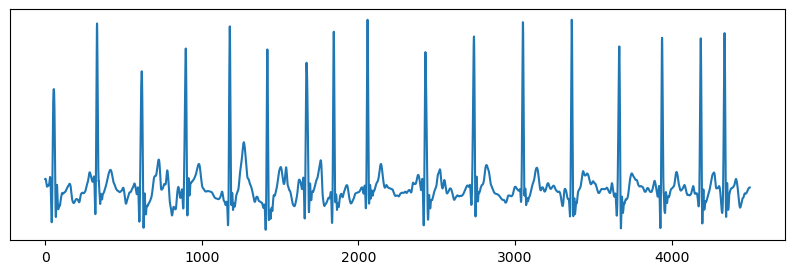

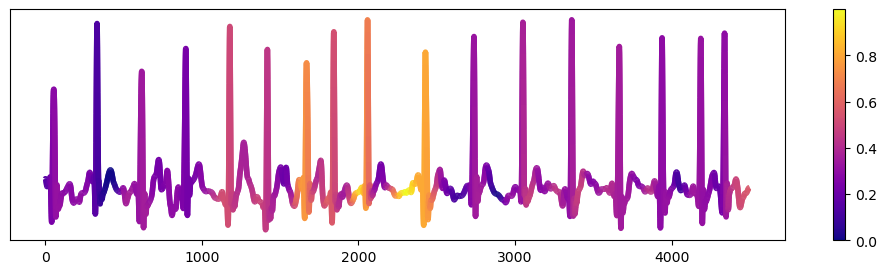

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import signal_screen
import signal_screen_tools

# 假设你已经有一个训练好的模型 `model` 和测试数据 `X_test` 和 `y_test`

# 筛选 AF (标签为0) 的第一个样本
af_sample = np.where(y_test == 0)[0][10]  # 选择第一个 AF 样本

# ------------------ 绘制原始信号图 ------------------
# 创建原始信号图
fig1, ax1 = plt.subplots(figsize=(10, 3))
ax1.plot(X_test[af_sample, :].ravel())
ax1.get_yaxis().set_visible(False)  # 去掉纵坐标

# 显示原始信号图
plt.show()
fig1.savefig("af_first_sample_original_signal.png")

# ------------------ 计算和绘制 Grad-CAM ------------------
# 计算第一个 AF 样本的 Grad-CAM
grad_cam = signal_screen.calculate_grad_cam(model=model,
                                            data=X_test[af_sample:af_sample+1, :],  # 每次传入一个样本，注意数据维度
                                            c=0,  # 因为是 AF 类，类别索引为 0
                                            use_relu=False)
grad_cam = np.average(grad_cam, axis=0)  # 平均 Grad-CAM 输出

# 创建 Grad-CAM 图
fig2, ax2 = plt.subplots(figsize=(12.5, 3))
signal_screen_tools.plot_with_gradient(ax=ax2, y=X_test[af_sample, :].ravel(), gradient=grad_cam, title="")
ax2.get_yaxis().set_visible(False)  # 去掉纵坐标

# 显示 Grad-CAM 图
plt.show()
fig2.savefig("af_first_sample_grad_cam.png")


In [ ]:
import numpy as np
import tensorflow as tf
def add_gaussian_noise(data, snr):
    data_power = np.mean(data**2)
    noise_power = data_power / (10 ** (snr / 10))
    noise = np.sqrt(noise_power) * (np.random.randn(*data.shape))
    noisy_data = data + noise
    return noisy_data

In [208]:
import numpy as np

def add_low_frequency_noise_multidim(data, snr, frequency_range=(0, 5), sample_rate=300):
    data_power = np.mean(data ** 2)
    noise_power = data_power / (10 ** (snr / 10))
    t = np.arange(data.shape[-1]) / sample_rate 
    noise_frequencies = np.random.uniform(frequency_range[0], frequency_range[1], size=data.shape[-1])
    noise = np.sqrt(noise_power) * np.sin(2 * np.pi * noise_frequencies * t)
    noisy_data = data + noise[None, ...] 
    
    return noisy_data

In [209]:
X_test_noisy = add_low_frequency_noise_multidim(X_test,0)

In [210]:
evaluate_model(model,X_test_noisy ,y_test)

Precision: 0.6092206339729013
Recall: 0.6254909493778659
F1 Score: 0.5905125159848065
Accuracy: 0.7864038616251006
Class 1 - Precision: 0.711764705882353, Recall: 0.5330396475770925, F1 Score: 0.6095717884130982
Class 2 - Precision: 0.8293413173652695, Recall: 0.9227181878747501, F1 Score: 0.8735414695679596
Class 3 - Precision: 0.7573149741824441, Recall: 0.5962059620596206, F1 Score: 0.667172100075815
Class 4 - Precision: 0.13846153846153847, Recall: 0.45, F1 Score: 0.21176470588235297
Class 1 Accuracy: 0.9376508447304908
Class 2 Accuracy: 0.8386967015285599
Class 3 Accuracy: 0.8234111021721641
Class 4 Accuracy: 0.9730490748189863


In [211]:
X_test_noisy = add_low_frequency_noise_multidim(X_test,5)

In [212]:
evaluate_model(model,X_test_noisy ,y_test)

Precision: 0.7489557714816725
Recall: 0.7080876156103422
F1 Score: 0.7243456907420831
Accuracy: 0.8483507642799678
Class 1 - Precision: 0.8169014084507042, Recall: 0.7665198237885462, F1 Score: 0.7909090909090909
Class 2 - Precision: 0.856379821958457, Recall: 0.9613590939373751, F1 Score: 0.9058380414312618
Class 3 - Precision: 0.8488576449912126, Recall: 0.6544715447154471, F1 Score: 0.739097169089518
Class 4 - Precision: 0.47368421052631576, Recall: 0.45, F1 Score: 0.46153846153846156
Class 1 Accuracy: 0.9629927594529365
Class 2 Accuracy: 0.8793242156074015
Class 3 Accuracy: 0.8628318584070797
Class 4 Accuracy: 0.9915526950925181


In [213]:
import numpy as np

def add_high_frequency_noise_multidim(data, snr, frequency_range=(0, 200), sample_rate=300):
    data_power = np.mean(data ** 2)
    noise_power = data_power / (10 ** (snr / 10))
    t = np.arange(data.shape[-1]) / sample_rate 
    noise_frequencies = np.random.uniform(frequency_range[0], frequency_range[1], size=data.shape[-1])
    noise = np.sqrt(noise_power) * np.sin(2 * np.pi * noise_frequencies * t)
    noisy_data = data + noise[None, ...] 
    
    return noisy_data

In [214]:
X_test_noisy = add_high_frequency_noise_multidim(X_test,0)

In [215]:
evaluate_model(model,X_test_noisy,y_test)

Precision: 0.6064119128072616
Recall: 0.6107826640776862
F1 Score: 0.5880579239015623
Accuracy: 0.7855993563958166
Class 1 - Precision: 0.7, Recall: 0.5242290748898678, F1 Score: 0.5994962216624684
Class 2 - Precision: 0.827072152653548, Recall: 0.9240506329113924, F1 Score: 0.8728760226557584
Class 3 - Precision: 0.7504273504273504, Recall: 0.5948509485094851, F1 Score: 0.6636432350718064
Class 4 - Precision: 0.14814814814814814, Recall: 0.4, F1 Score: 0.21621621621621623
Class 1 Accuracy: 0.9360418342719228
Class 2 Accuracy: 0.8374899436846339
Class 3 Accuracy: 0.8209975864843122
Class 4 Accuracy: 0.9766693483507642


In [216]:
X_test_noisy = add_high_frequency_noise_multidim(X_test,5)

In [217]:
evaluate_model(model,X_test_noisy ,y_test)

Precision: 0.7548251376502936
Recall: 0.704702156646354
F1 Score: 0.7250225399843216
Accuracy: 0.8459372485921158
Class 1 - Precision: 0.7889908256880734, Recall: 0.7577092511013216, F1 Score: 0.7730337078651686
Class 2 - Precision: 0.8573127229488704, Recall: 0.960692871419054, F1 Score: 0.9060634621426327
Class 3 - Precision: 0.843585237258348, Recall: 0.6504065040650406, F1 Score: 0.7345065034429992
Class 4 - Precision: 0.5294117647058824, Recall: 0.45, F1 Score: 0.48648648648648646
Class 1 Accuracy: 0.9593724859211585
Class 2 Accuracy: 0.8797264682220435
Class 3 Accuracy: 0.8604183427192277
Class 4 Accuracy: 0.9923572003218021
